# **1. Data Preparation**

## 1.1. Importing Libraries

In [5]:
import gradio as gr
import joblib
from skimage.transform import resize
import io
import base64
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


## 1.2. Loading Dataset

In [6]:
mnist = fetch_openml('mnist_784', version = 1, as_frame=False)
X,y = mnist['data'], mnist['target']
X,y = shuffle(X, y, random_state=42)
y = y.astype(np.uint8)

## 1.3. Splitting Dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, random_state=42, stratify=y
)


## 1.4. Scaling Data

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled = scaler.transform(X_test.astype(np.float64))


## 1.5. Summary

In [9]:
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Unique labels:", np.unique(y_train))


Training set shape: (60000, 784)
Test set shape: (10000, 784)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


#  **2. Model Training**

## 2.1. Train SGDClassifier

In [10]:
sgd_clf = SGDClassifier(loss='hinge',random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_scaled, y_train)
sgd_pred = sgd_clf.predict(X_test_scaled)
sgd_acc = accuracy_score(y_test, sgd_pred)
print(f"SGDClassifier Accuracy: {sgd_acc:.4f}")

SGDClassifier Accuracy: 0.8912


## 2.2. Train RandomForestClassifier

In [11]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print(f"RandomForestClassifier Accuracy: {rf_acc:.4f}")

RandomForestClassifier Accuracy: 0.9708


# **3. Model Evaluation (Confusion Matrix, Classification Report, Metrics)**

## 3.1. Evaluate SGDClassifier (Linear SVM)

SGDClassifier Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       986
           1       0.97      0.96      0.96      1125
           2       0.93      0.86      0.90       999
           3       0.94      0.83      0.88      1020
           4       0.94      0.89      0.91       975
           5       0.90      0.81      0.85       902
           6       0.94      0.94      0.94       982
           7       0.94      0.91      0.93      1042
           8       0.62      0.93      0.74       975
           9       0.90      0.84      0.87       994

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.91      0.89      0.89     10000



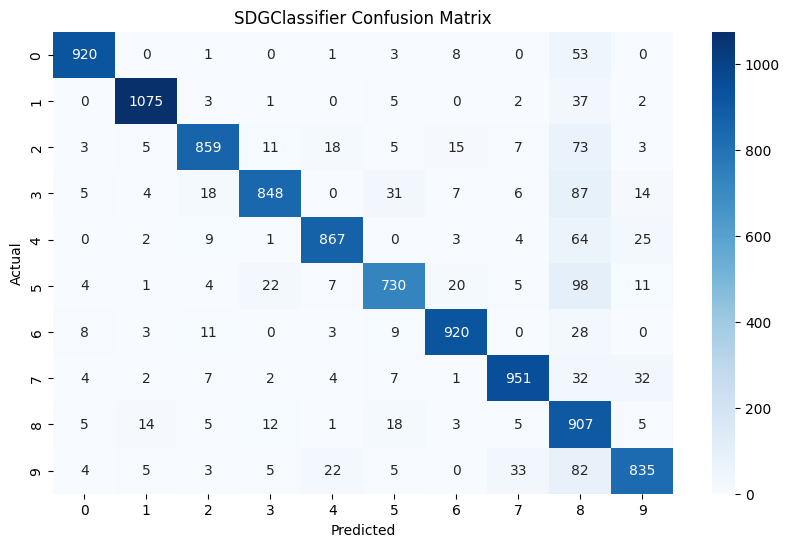

In [12]:
sgd_cm = confusion_matrix(y_test, sgd_pred)
sgd_cr = classification_report(y_test, sgd_pred)
print("SGDClassifier Classification Report:\n", sgd_cr)

plt.figure(figsize=(10, 6))
sns.heatmap(sgd_cm, annot=True, fmt='d', cmap='Blues')
plt.title("SDGClassifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

##  3.2. Evaluate RandomForestClassifier

RandomForestClassifier Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       986
           1       0.99      0.99      0.99      1125
           2       0.97      0.97      0.97       999
           3       0.97      0.95      0.96      1020
           4       0.97      0.98      0.97       975
           5       0.98      0.96      0.97       902
           6       0.97      0.98      0.98       982
           7       0.97      0.97      0.97      1042
           8       0.96      0.96      0.96       975
           9       0.96      0.95      0.95       994

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



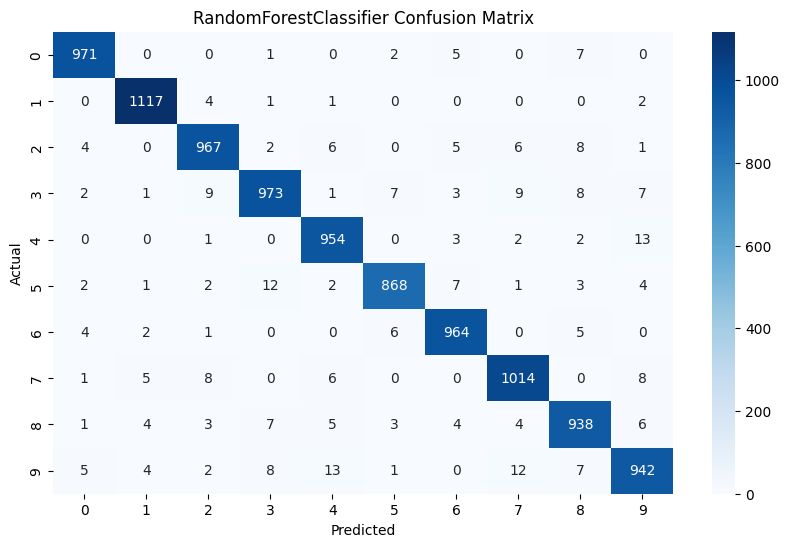

In [13]:
rf_cm = confusion_matrix(y_test,rf_pred)
rf_cr = classification_report(y_test, rf_pred)
print("RandomForestClassifier Classification Report:\n", rf_cr)

plt.figure(figsize=(10, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title("RandomForestClassifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# **4. Error Visualization (Worst-Case Misclassifications)**

## 4.1: Identify Misclassified Instances (RandomForestClassifier)

In [14]:
# Get indexes of incorrect predictions
misclassified_idx = np.where(rf_pred != y_test)[0]

# Extract actual and predicted labels for those
misclassified_actual = y_test[misclassified_idx]
misclassified_pred = rf_pred[misclassified_idx]

# Combine and count (actual, predicted) pairs
from collections import Counter

error_pairs = list(zip(misclassified_actual, misclassified_pred))
most_common_errors = Counter(error_pairs).most_common(5)
print("Most Frequent Misclassifications (Actual → Predicted):")
for (actual, predicted), count in most_common_errors:
    print(f"{actual} → {predicted}: {count} times")

Most Frequent Misclassifications (Actual → Predicted):
4 → 9: 13 times
9 → 4: 13 times
5 → 3: 12 times
9 → 7: 12 times
3 → 2: 9 times


## 4.2: Plot Example Misclassified Images (e.g., 9→4)

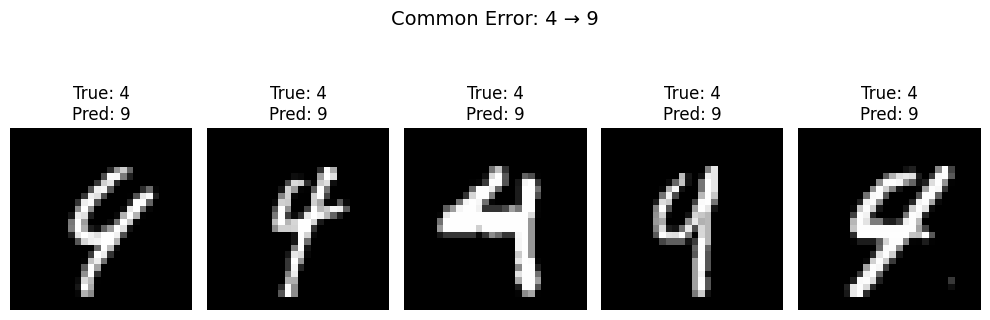

In [15]:
target_actual, target_predicted = most_common_errors[0][0]

target_indices = [
    idx for idx in misclassified_idx
    if y_test[idx] == target_actual and rf_pred[idx] == target_predicted
]

# Plot the first 5 examples
plt.figure(figsize=(10, 4))
for i, idx in enumerate(target_indices[:5]):
    image = X_test[idx].reshape(28, 28)
    plt.subplot(1, 5, i+1)
    plt.imshow(image, cmap="gray")
    plt.title(f"True: {y_test[idx]}\nPred: {rf_pred[idx]}")
    plt.axis('off')

plt.suptitle(f"Common Error: {target_actual} → {target_predicted}", fontsize=14)
plt.tight_layout()
plt.show()


## 5.1. Load Trained Model + Scaler

In [16]:
joblib.dump(rf_clf, 'rf_clf.joblib')
joblib.dump(scaler, "scaler.joblib")

rf_clf = joblib.load("rf_clf.joblib")
scaler = joblib.load("scaler.joblib")


## 5.2. Define Preprocessing + Prediction Function